In [1]:
import sys
sys.path.insert(1, "./src")

In [2]:
from pathlib import Path
import yaml
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from transformers import set_seed


from datasets.ner_dataset import get_ner_dataset
from models.bert_model import PretrainedBertNER
from utils.metrics import Statistics
from utils.log_reader import TensorBoardReader
from anonymization.ref_book import ReferenceBookAnonymization

In [3]:
set_seed(42)

In [4]:
# Data config initialisation
i2b2_2006_data_config = yaml.load(open("configs/i2b2-2006_data_config.yaml", 'r'), Loader=yaml.Loader)
i2b2_2014_data_config = yaml.load(open("configs/i2b2-2014_data_config.yaml", 'r'), Loader=yaml.Loader)

In [5]:
# Model config initialisation
bert_base_model_config = yaml.load(open("configs/bert-base_model_config.yaml", 'r'), Loader=yaml.Loader)
bert_large_model_config = yaml.load(open("configs/bert-large_model_config.yaml", 'r'), Loader=yaml.Loader)

In [6]:
# Anonymization config initialisation
anon_config = yaml.load(open("configs/ref_book_anonymization_config.yaml", 'r'), Loader=yaml.Loader)

### Структура сохранённых моделей:
1. В ```./bert-base/lightning_logs/``` должны храниться модели, основанные на базовом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
2. В ```./bert-large/lightning_logs/``` должны храниться модели, основанные на большом предобученном BERT
    1. Version 0 --- обученная на датасете i2b2 2006 с учётом регистра
    2. Version 1 --- обученная на датасете i2b2 2006 без учёта регистра
    3. Version 2 --- обученная на датасете i2b2 2014 с учётом регистра
    4. Version 3 --- обученная на датасете i2b2 2014 без учёта регистра
    5. Version 4 --- обученная на обезличенном датасете i2b2 2014 без учёта регистра

### Этап 1: Сравнение результатов на наборе данных i2b2 2014
Сравнение будет включает в себя измерение метрик Recall, Precision и $F_1$ score для следующий моделей:
* BERT-base-cased
* BERT-base-uncased
* BERT-large-cased
* BERT-large-uncased

#### BERT-base-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

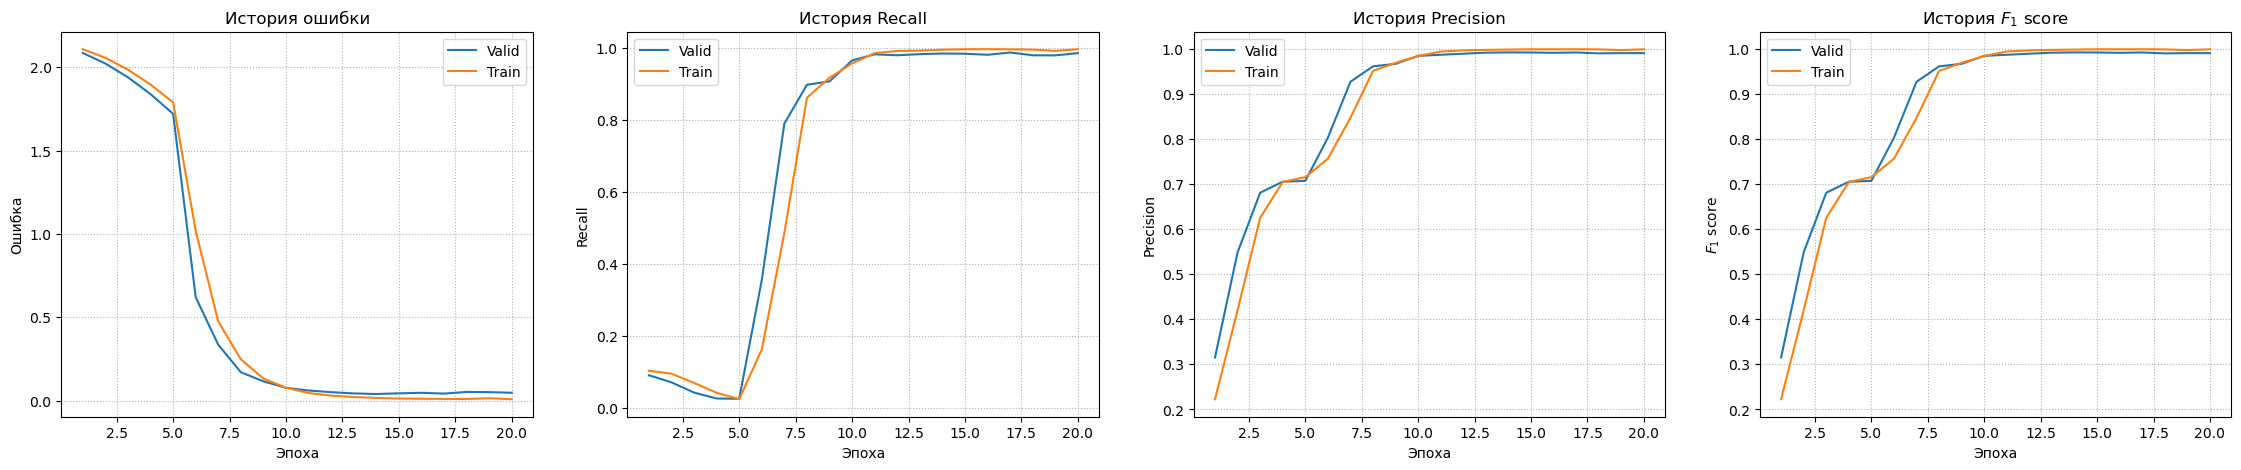

In [7]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [8]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-base-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


In [9]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(2)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [10]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1             0.991321861743927
     test_precision          0.991321861743927
       test_recall          0.9874463677406311
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9874463677406311,
  'test_precision': 0.991321861743927,
  'test_f1': 0.991321861743927}]

              precision    recall  f1-score   support

        NAME     0.9854    0.9824    0.9839      4045
  PROFESSION     0.0000    0.0000    0.0000        12
    LOCATION     0.9283    0.9736    0.9504      3072
         AGE     0.9617    0.9892    0.9753       279
        DATE     0.9986    0.9977    0.9981      5543
          ID     0.9930    0.9957    0.9943      1842
     CONTACT     0.9948    0.9914    0.9931       581
           O     0.9625    0.9930    0.9775     35789

   micro avg     0.9674    0.9913    0.9792     51163
   macro avg     0.8530    0.8654    0.8591     51163
weighted avg     0.9674    0.9913    0.9792     51163



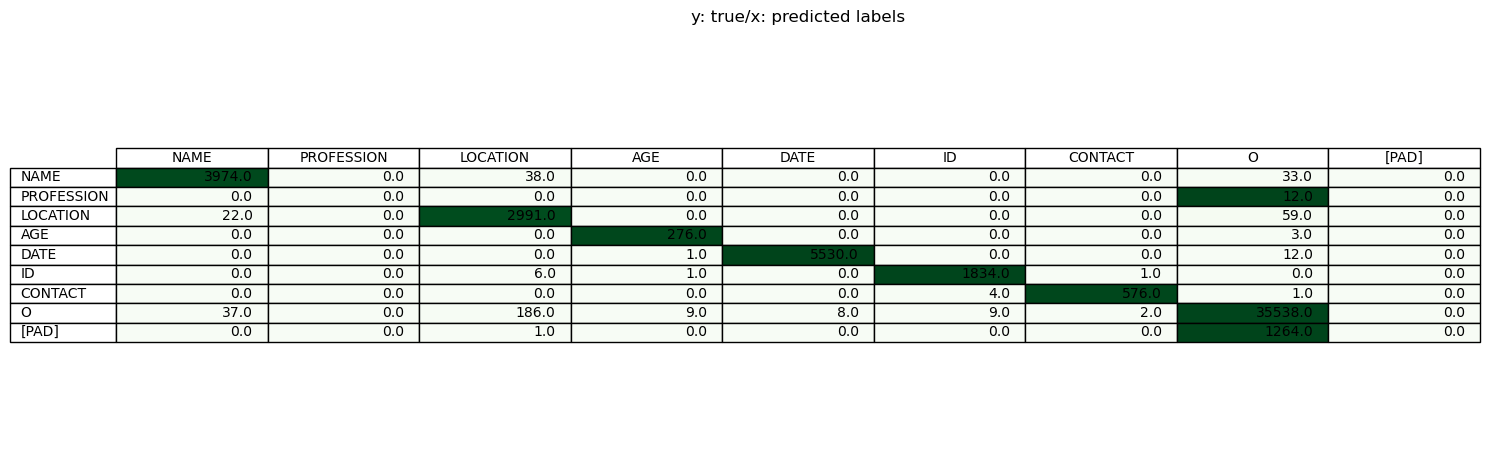

Wrongly predicted examples:
_____ Record 211-02 _____
| Sentence:    | Record | date | : | 2093 | -    | 08   | -    | 19   | August | 19   | ,    | 2093 | John | Ussery | , | M | . | D | . | Worthington | - | Internal | Medicine | 80       | Shattuck | Street   | , | IM       | 270      | Citrus   | Ridge    | , | MT       | 43782    | Re | : | Russell | Urban | WRH      | # | 4722064 | Dear | Dr | . | Ussery | : | I | had | the | pleasure | of | seeing | Mr | . | Russell | Urban | in | Cardiology | Clinic | today | . | As | you | know | , | Mr | . | Urban | is | a | very | pleasant | 50  | - | year | - | old | gentleman | who |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | DATE   | DATE | DATE | DATE | NAME | NAME   | O | O | O | O | O | LOCATION    | O | O        | O        | LOCATION | LOCATION | LOCATION | O | O        | O        | LOCATION | LOCATION | O | LOCATION | LOCATION | O  | O | NAME    | NAME  | LOCATION | O | ID      | O    | O  | O | NAME   | 

In [11]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-base-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

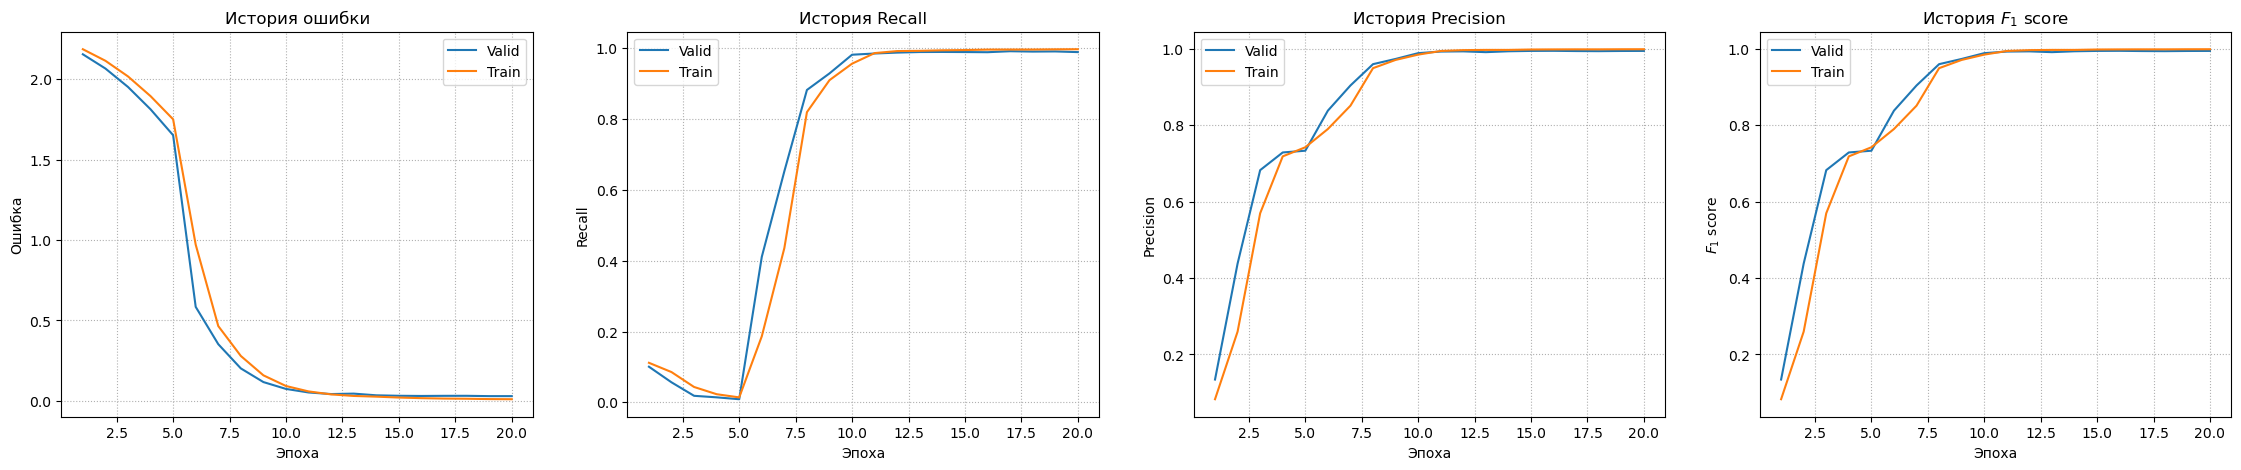

In [12]:
t_reader = TensorBoardReader(Path(bert_base_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [13]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-base-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [14]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(3)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [15]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9942045211791992
     test_precision         0.9942045211791992
       test_recall          0.9913195967674255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9913195967674255,
  'test_precision': 0.9942045211791992,
  'test_f1': 0.9942045211791992}]

              precision    recall  f1-score   support

        NAME     0.9733    0.9901    0.9816      3023
  PROFESSION     0.0000    0.0000    0.0000        13
    LOCATION     0.9300    0.9789    0.9538      2227
         AGE     0.9913    0.9942    0.9927       343
        DATE     0.9984    0.9972    0.9978      5715
          ID     0.9923    0.9967    0.9945      1804
     CONTACT     0.9948    0.9914    0.9931       584
           O     0.9688    0.9953    0.9819     37538

   micro avg     0.9718    0.9942    0.9829     51247
   macro avg     0.8561    0.8680    0.8619     51247
weighted avg     0.9717    0.9942    0.9828     51247



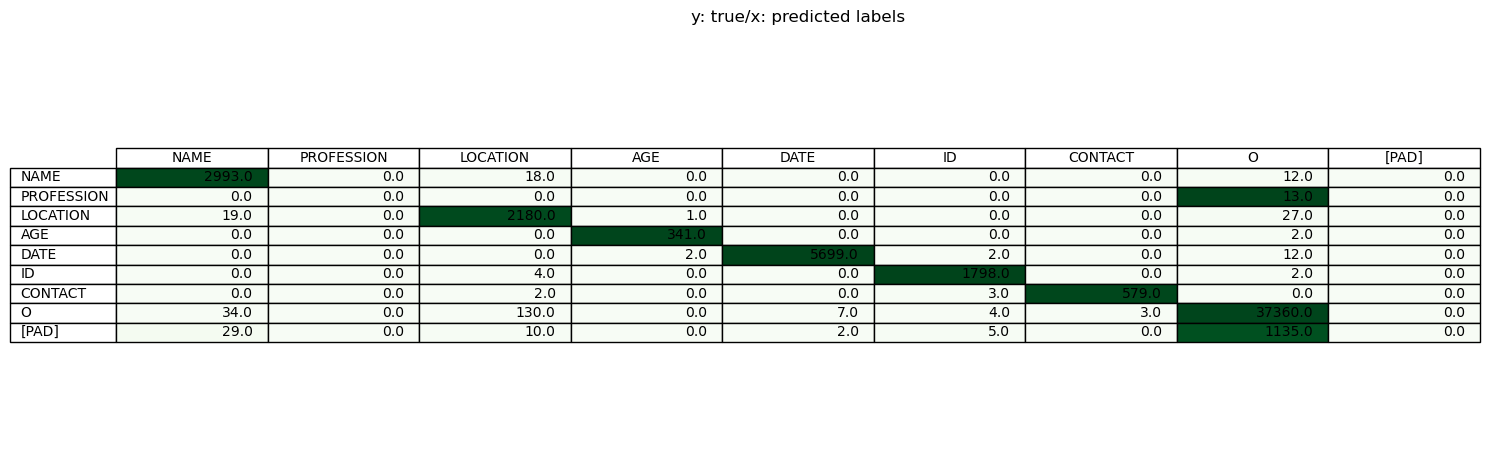

Wrongly predicted examples:
_____ Record 378-01 _____
| Sentence:    | record | date | : | 2062 | -    | 09   | -    | 18   | tammy | umphrey | pdi      | unit | no | : | 094 | -  | 22 | -  | 07 | cleveland | public   | institute | internal | medicine | date | : | september | 18   | ,    | 2062 | medications | : | glynase | 3 | mg | q | . | a | . | m | . | , | glucophage | 500 | mg | q | . | p | . | m | . | , | ultram | 50 | mg | b | . | i | . | d | . | , | synthroid | ? | dose | q | . | d | . | , | premarin | 0 | . | 625 | mg | q | . | d | . | , | monopril | 40 |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME  | NAME    | LOCATION | O    | O  | O | ID  | ID | ID | ID | ID | LOCATION  | LOCATION | LOCATION  | O        | O        | O    | O | DATE      | DATE | DATE | DATE | O           | O | O       | O | O  | O | O | O | O | O | O | O | O          | O   | O  | O | O | O | O | O | O | O | O      | O  | O  | O | O | O | O | O | O | O | O         | O | O    

In [16]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-cased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

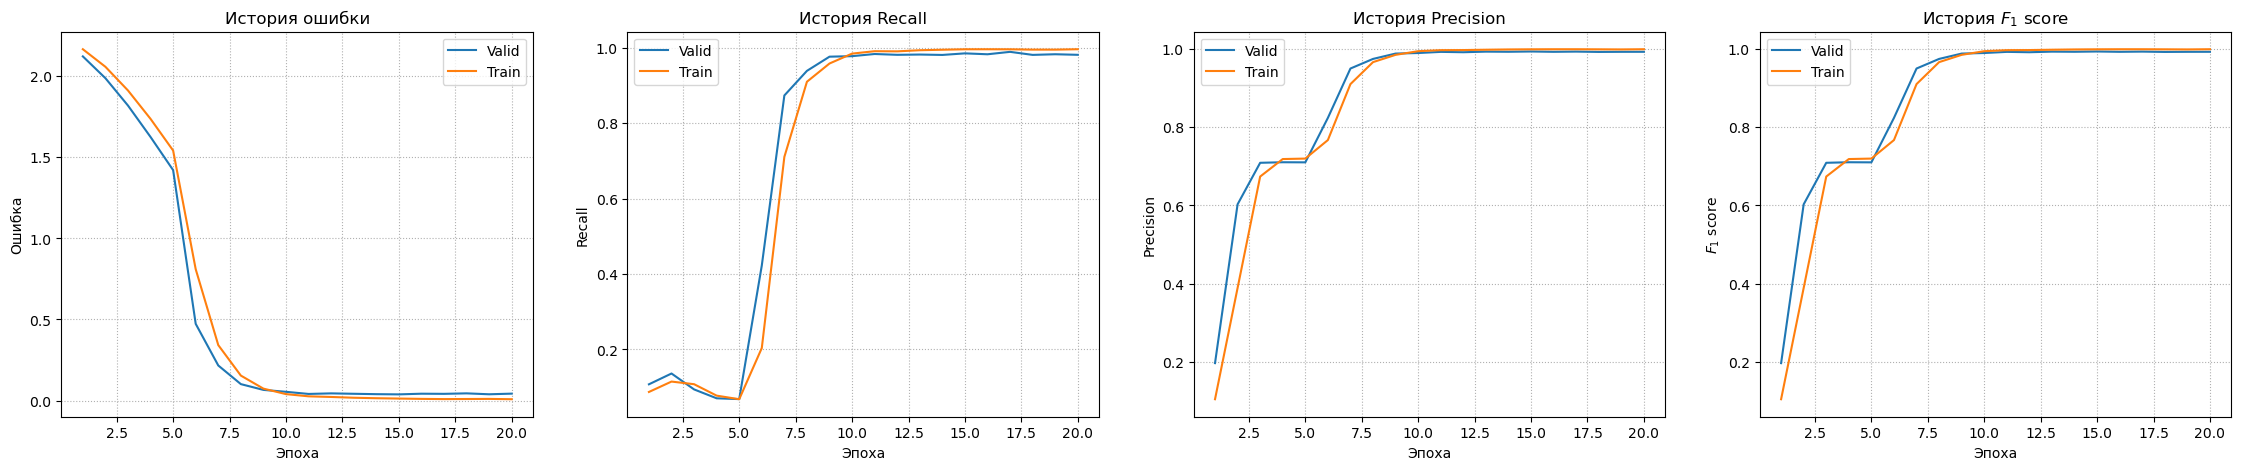

In [17]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(2)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [18]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=False,
                               pretrained_tokenizer="bert-large-cased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (558 > 512). Running this sequence through the model will result in indexing errors


In [19]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(2)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [20]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1             0.992670476436615
     test_precision          0.992670476436615
       test_recall           0.989918053150177
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.989918053150177,
  'test_precision': 0.992670476436615,
  'test_f1': 0.992670476436615}]

              precision    recall  f1-score   support

        NAME     0.9833    0.9909    0.9871      4045
  PROFESSION     0.0000    0.0000    0.0000        12
    LOCATION     0.9401    0.9753    0.9573      3072
         AGE     0.9964    0.9785    0.9873       279
        DATE     0.9978    0.9984    0.9981      5543
          ID     1.0000    0.9919    0.9959      1842
     CONTACT     0.9781    1.0000    0.9889       581
           O     0.9633    0.9939    0.9783     35789

   micro avg     0.9687    0.9927    0.9805     51163
   macro avg     0.8574    0.8661    0.8616     51163
weighted avg     0.9687    0.9927    0.9805     51163



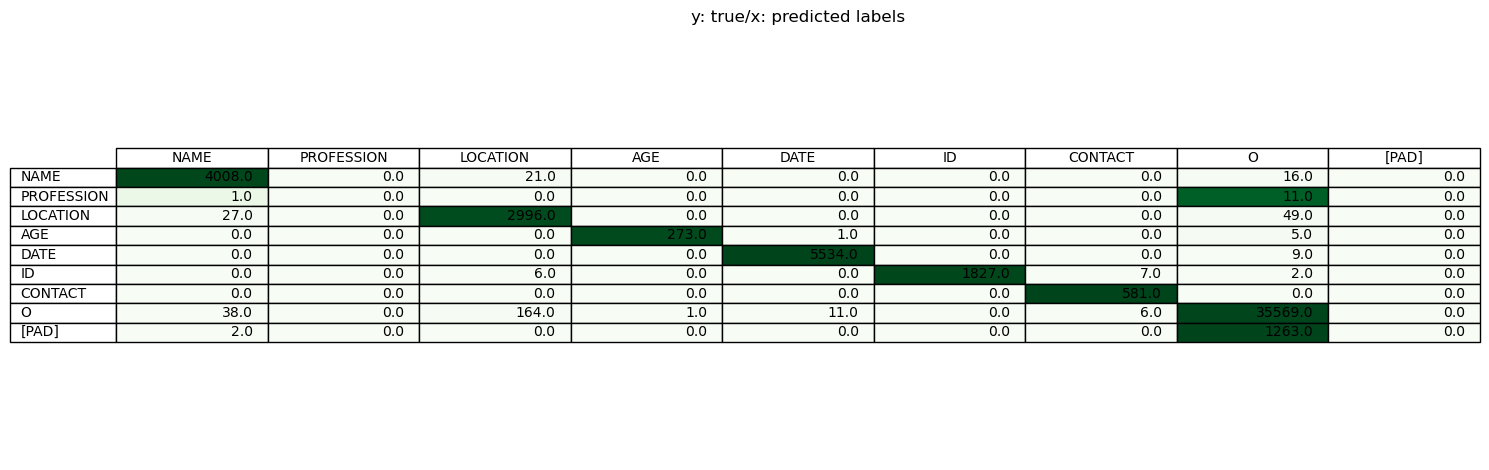

Wrongly predicted examples:
_____ Record 118-03 _____
| Sentence:    | Record | date | : | 2117 | -    | 08   | -    | 26   | Usrey | ,    | Anthony | MRN | : | 6444877 | DOB | : | 8    | /    | 11   | /    | 2062 | August | 26   | ,    | 2117 | Sisters  | Of       | Providence | Hospital | CC | : | f | / | u | pancreatitis | HPI | : | 55  | y | . | o | . | male | Columbian | speaking | ( | hospital | interpreter | present | ) | presents | for | follow | up | . | He | was | admitted | to | PNC      | on | 7    | /    | 12   | /    | 17   | for | further | management | of | his | pancreatitis | secondary | to | an | ERCP | / |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | NAME  | NAME | NAME    | O   | O | ID      | O   | O | DATE | DATE | DATE | DATE | DATE | DATE   | DATE | DATE | DATE | LOCATION | LOCATION | LOCATION   | LOCATION | O  | O | O | O | O | O            | O   | O | AGE | O | O | O | O | O    | LOCATION  | O        | O | O        | O           | O

In [21]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

#### BERT-large-uncased

Графики обучения:
(Метрика recall посчитана без учёта класса 'other', отвечающего за неличные сущности).

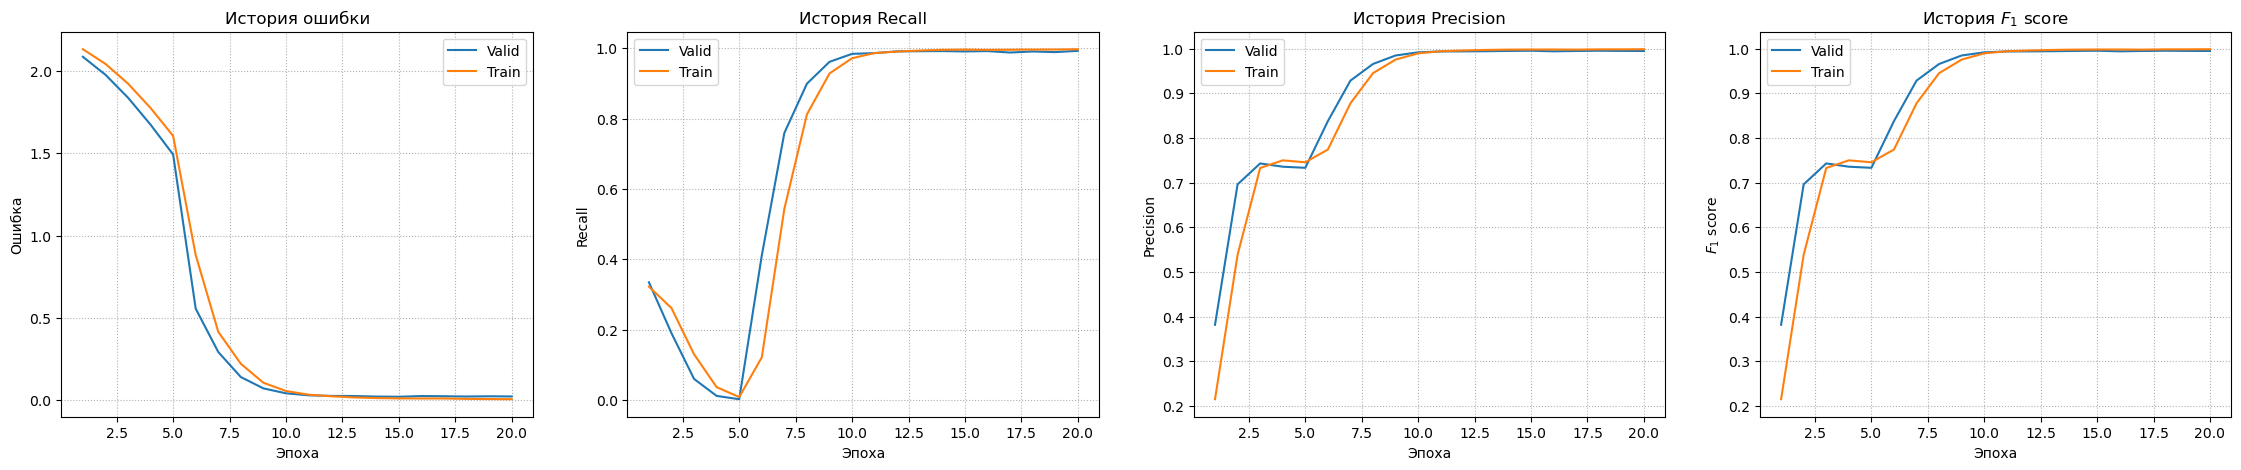

In [22]:
t_reader = TensorBoardReader(Path(bert_large_model_config["log_dir"]) / Path("lightning_logs"))
t_reader.plot_tensorboard_graphics(3)

Из обучения взята модель с лучшим показателем в метрике recall без учёта класса 'other'. Посмотрим на её метрики на валидационных данных.

In [23]:
# Data processing
test_dataset = get_ner_dataset(data_type=i2b2_2014_data_config['val_data_type'],
                               path_to_folder=i2b2_2014_data_config["validate_data_path"],
                               is_uncased=True,
                               pretrained_tokenizer="bert-large-uncased",
                               max_length=i2b2_2014_data_config["max_token_number"],
                               eq_max_padding=i2b2_2014_data_config["eq_max_padding"])
test_dataloader = DataLoader(test_dataset, shuffle=False,
                             batch_size=i2b2_2014_data_config["batch_size"],
                             collate_fn=test_dataset.get_collate_fn())

Token indices sequence length is longer than the specified maximum sequence length for this model (653 > 512). Running this sequence through the model will result in indexing errors


In [24]:
# Model initialisation
path_to_checkpoint = t_reader.get_ckpt_path(3)
ner_model = PretrainedBertNER.load_from_checkpoint(path_to_checkpoint)
print(ner_model)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


PretrainedBertNER(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [25]:
# Testing
trainer_args = {
    "accelerator": "gpu",
    "logger": False
}
trainer = pl.Trainer(**trainer_args, enable_progress_bar=True)
trainer.test(ner_model, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_recall', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_precision', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(
/home/dmitry-indenbom/anaconda3/lib/python3.10/site-packages/pytorch_lightning/core/module.py:481: UserWarning: You called `self.log('test_f1', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.9950436353683472
     test_precision         0.9950436353683472
       test_recall          0.9922678470611572
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_recall': 0.9922678470611572,
  'test_precision': 0.9950436353683472,
  'test_f1': 0.9950436353683472}]

              precision    recall  f1-score   support

        NAME     0.9727    0.9904    0.9815      3023
  PROFESSION     1.0000    0.3077    0.4706        13
    LOCATION     0.9454    0.9793    0.9621      2227
         AGE     0.9552    0.9942    0.9743       343
        DATE     0.9983    0.9984    0.9983      5715
          ID     0.9934    0.9956    0.9945      1804
     CONTACT     0.9748    0.9949    0.9847       584
           O     0.9696    0.9961    0.9827     37538

   micro avg     0.9726    0.9950    0.9837     51247
   macro avg     0.9762    0.9071    0.9186     51247
weighted avg     0.9727    0.9950    0.9837     51247



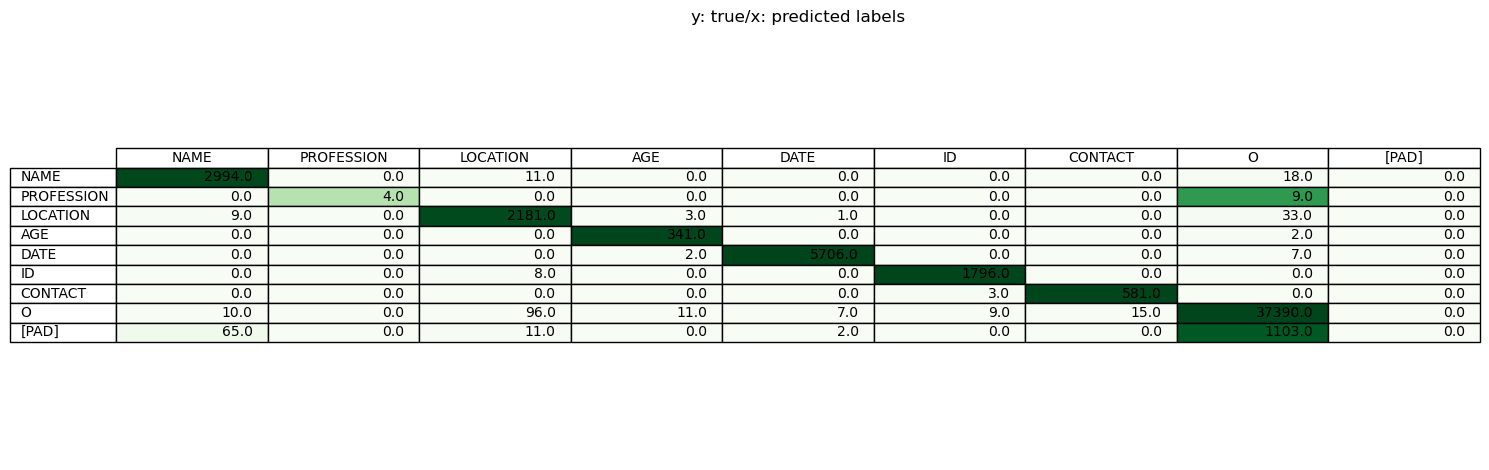

Wrongly predicted examples:
_____ Record 374-05 _____
| Sentence:    | record | date | : | 2135 | -    | 08   | -    | 03   | wsa      | team | 4 | surgery | admission | note | patient | : | mckee | ,    | norma | mrn | : | 6987776 | date | : | 8    | /    | 3    | /    | 2135 | pcp | : | dr | . | robert | xenakis | attending | : | dr | . | kirk | senior | : | dr | . | huerta | intern | : | dr | . | dukes | cc | : | abdominal | pain | / | n | / | v | hpi | : | 60  | f | obese | s | / | p | exlap | / | tah | / | bso | / | appy | / | chole | ( | meyers |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | LOCATION | O    | O | O       | O         | O    | O       | O | NAME  | NAME | NAME  | O   | O | ID      | O    | O | DATE | DATE | DATE | DATE | DATE | O   | O | O  | O | NAME   | NAME    | O         | O | O  | O | NAME | O      | O | O  | O | NAME   | O      | O | O  | O | NAME  | O  | O | O         | O    | O | O | O | O | O   | O | AGE | O | O     | O | O | O | 

In [26]:
# Print metrics
stats = Statistics(ner_model, test_dataloader)
print(stats.get_classification_report())
stats.plot_confusion_matrix()
stats.print_random_failed_predictions()

Все классы кроме "PROFESSION" предсказываются с $Recall > 95\%$. Предположительно, это происходит из-за слабого представления класса в обучающей выборке. Для точности рассмотрим примеры ошибок его распознавания.

In [28]:
faults = stats.get_specific_failed_predictions('PROFESSION')

Wrongly predicted examples:
_____ Record 231-05 _____
| Sentence:    | record | date | : | 2098 | -    | 10   | -    | 11   | cardiology | coquille | valley   | hospital | reason | for | visit | : | 45  | y | o | seamstress | with | h | / | o | cad | , | renal | transplant | , | cva | , | here | for | cardiology | fu | after | having | been | inactivated | from | pancreas | transplant | list | . | interval | history | : | ms | . | fagan | notes | that | she | is | doing | very | well | . | she | does | not | have | any | chest | pain | and | only | rare | dyspnea | . | she | has | not | had | any | dizziness | and | lightheadedness | . | she | had | previously |
| True labels: | O      | O    | O | DATE | DATE | DATE | DATE | DATE | O          | LOCATION | LOCATION | LOCATION | O      | O   | O     | O | AGE | O | O | PROFESSION | O    | O | O | O | O   | O | O     | O          | O | O   | O | O    | O   | O          | O  | O     | O      | O    | O           | O    | O        | O     